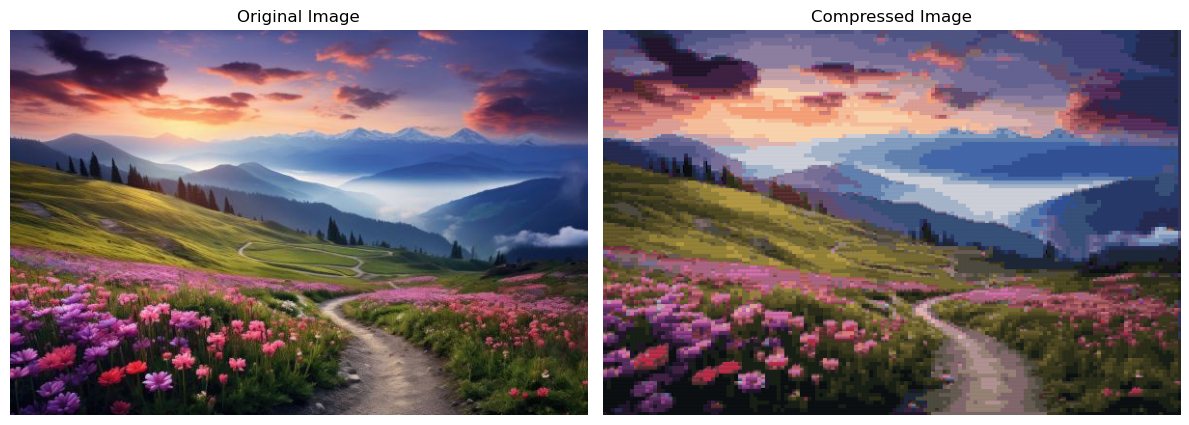

In [27]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def load_image(image_path):
    img = Image.open(image_path).convert('RGB')  
    return np.array(img)

def pad_image(img, block_size):
    pad_height = (block_size - img.shape[0] % block_size) % block_size
    pad_width = (block_size - img.shape[1] % block_size) % block_size
    return np.pad(img, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)

def create_codebook(image_blocks, num_codewords):
    kmeans = KMeans(n_clusters=num_codewords, random_state=42)
    kmeans.fit(image_blocks)
    return kmeans.cluster_centers_, kmeans.labels_

def encode_image(image_blocks, codebook):
    """Encode the image using the codebook."""
    encoded_indices = []
    for block in image_blocks:
        distances = np.linalg.norm(block - codebook, axis=1)
        encoded_indices.append(np.argmin(distances))
    return np.array(encoded_indices)

def decode_image(encoded_indices, codebook, block_shape):
    """Decode the indices back to an image."""
    reconstructed_blocks = []
    for index in encoded_indices:
        reconstructed_blocks.append(codebook[index])
    return np.array(reconstructed_blocks).reshape(-1, *block_shape)

def compress_image(image_path, num_codewords, block_size=4):
    """Compress and decompress an image using vector quantization."""
    img = load_image(image_path)
    padded_img = pad_image(img, block_size)
    
    # Divide the padded image into blocks
    blocks = [
        padded_img[i:i+block_size, j:j+block_size].flatten()
        for i in range(0, padded_img.shape[0], block_size)
        for j in range(0, padded_img.shape[1], block_size)
    ]
    
    codebook, _ = create_codebook(blocks, num_codewords)
    
    encoded_image = encode_image(blocks, codebook)
    
    reconstructed_blocks = decode_image(encoded_image, codebook, (block_size, block_size, 3))  # 3 channels for RGB
    
    # Reconstruct full image from blocks
    reconstructed_image = np.zeros_like(padded_img)
    idx = 0
    for i in range(0, padded_img.shape[0], block_size):
        for j in range(0, padded_img.shape[1], block_size):
            reconstructed_image[i:i+block_size, j:j+block_size] = reconstructed_blocks[idx]
            idx += 1
    
    # Crop the reconstructed image back to original size
    reconstructed_image = reconstructed_image[:img.shape[0], :img.shape[1]]
    return img, reconstructed_image

def display_images(original, compressed, title1="Original Image", title2="Compressed Image"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original)
    axes[0].set_title(title1)
    axes[0].axis('off')  
    
    # Compressed image
    axes[1].imshow(compressed)
    axes[1].set_title(title2)
    axes[1].axis('off')  
    
    plt.tight_layout()
    plt.show()

original_img, compressed_img = compress_image('nature.jpg', num_codewords=64)
display_images(original_img, compressed_img.astype(np.uint8))

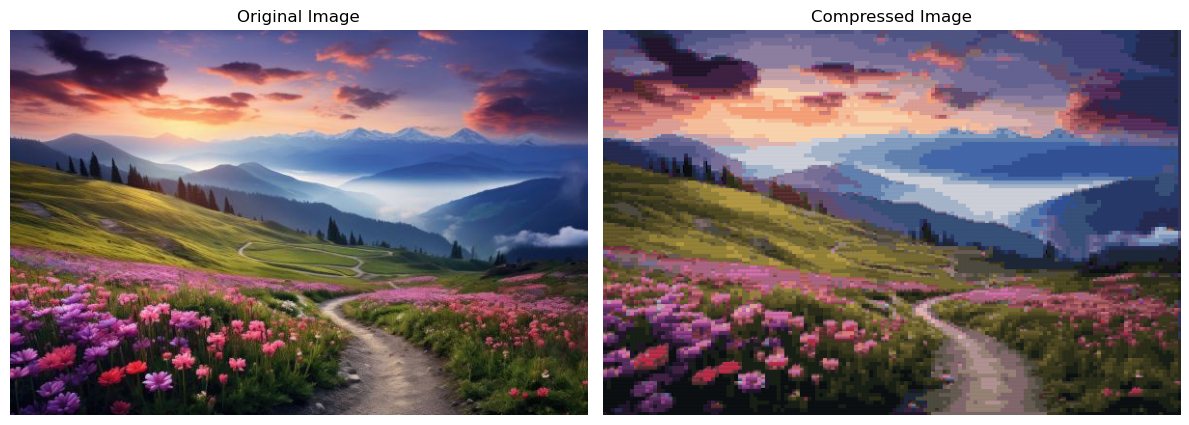

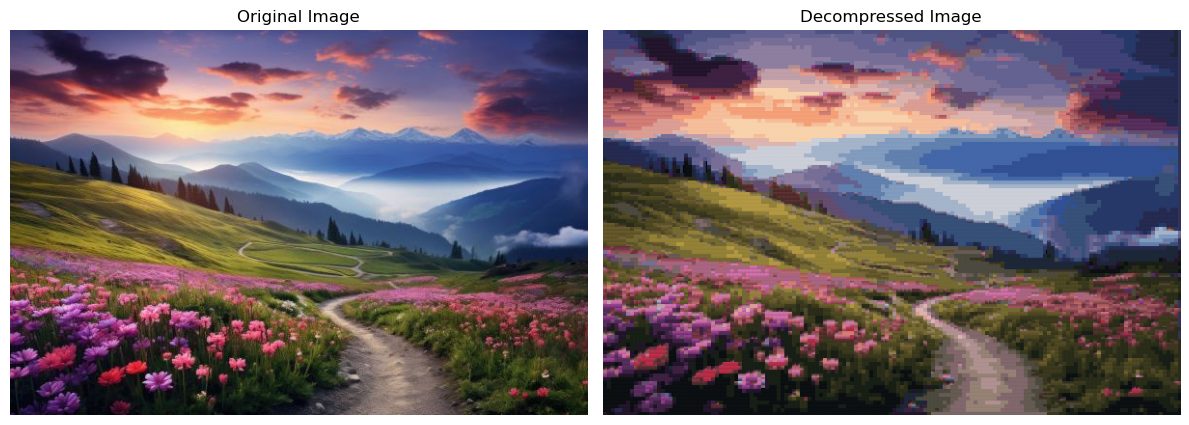

In [28]:
def decompress_image(encoded_indices, codebook, original_shape, block_size=4):
    """Decompress the encoded image using the codebook and reconstruct it to the original shape."""
    # Decode the indices back to blocks
    reconstructed_blocks = decode_image(encoded_indices, codebook, (block_size, block_size, 3))

    # Reconstruct the full image from blocks
    padded_img_shape = (
        original_shape[0] + (block_size - original_shape[0] % block_size) % block_size,
        original_shape[1] + (block_size - original_shape[1] % block_size) % block_size,
        3
    )
    reconstructed_image = np.zeros(padded_img_shape, dtype=np.uint8)
    idx = 0
    for i in range(0, padded_img_shape[0], block_size):
        for j in range(0, padded_img_shape[1], block_size):
            reconstructed_image[i:i+block_size, j:j+block_size] = reconstructed_blocks[idx]
            idx += 1

    # Crop the reconstructed image back to the original size
    reconstructed_image = reconstructed_image[:original_shape[0], :original_shape[1]]
    return reconstructed_image

def compress_and_decompress_image(image_path, num_codewords, block_size=4):
    """Compress, decompress, and display images side by side."""
    # Load and pad the image
    img = load_image(image_path)
    padded_img = pad_image(img, block_size)

    # Divide the padded image into blocks
    blocks = [
        padded_img[i:i+block_size, j:j+block_size].flatten()
        for i in range(0, padded_img.shape[0], block_size)
        for j in range(0, padded_img.shape[1], block_size)
    ]

    codebook, labels = create_codebook(blocks, num_codewords)

    encoded_image = encode_image(blocks, codebook)

    # Decode image (compressed)
    compressed_img = decode_image(encoded_image, codebook, (block_size, block_size, 3))
    compressed_full_img = np.zeros_like(padded_img)
    idx = 0
    for i in range(0, padded_img.shape[0], block_size):
        for j in range(0, padded_img.shape[1], block_size):
            compressed_full_img[i:i+block_size, j:j+block_size] = compressed_img[idx]
            idx += 1
    compressed_full_img = compressed_full_img[:img.shape[0], :img.shape[1]]

    decompressed_img = decompress_image(encoded_image, codebook, img.shape, block_size)

    display_images(img, compressed_full_img.astype(np.uint8), "Original Image", "Compressed Image")
    display_images(img, decompressed_img.astype(np.uint8), "Original Image", "Decompressed Image")

compress_and_decompress_image('nature.jpg', num_codewords=64)

Compression Ratio: 11.71


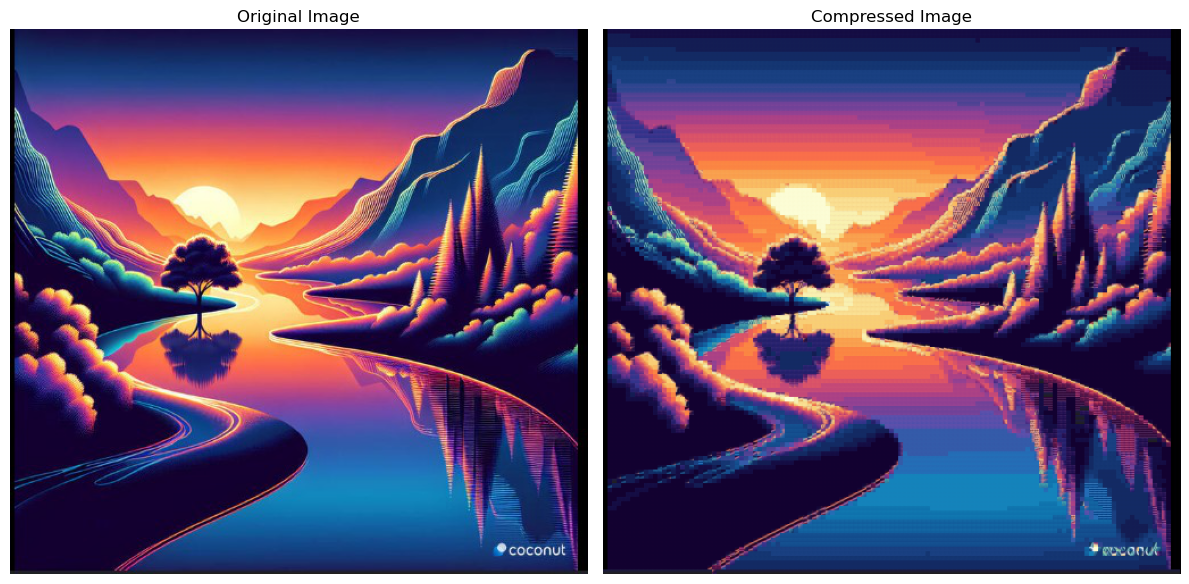

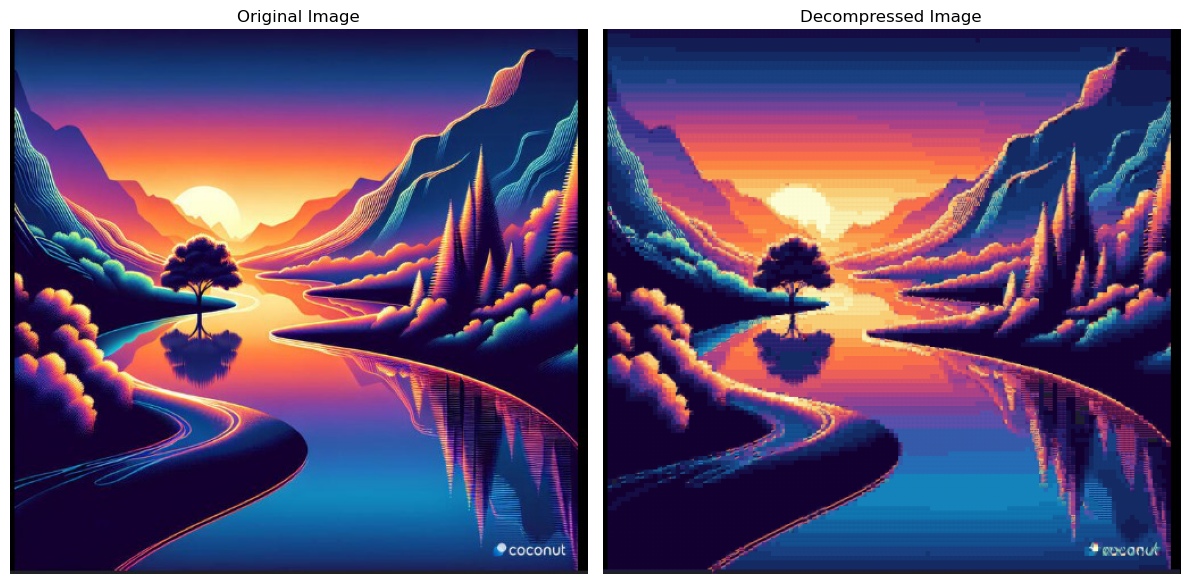

In [41]:
def decompress_image(encoded_indices, codebook, original_shape, block_size=4):

    reconstructed_blocks = [codebook[idx] for idx in encoded_indices]
#reconstruct the image
    padded_img_shape = (
        original_shape[0] + (block_size - original_shape[0] % block_size) % block_size,
        original_shape[1] + (block_size - original_shape[1] % block_size) % block_size,
        3
    )
    reconstructed_image = np.zeros(padded_img_shape, dtype=np.uint8)
    idx = 0
    for i in range(0, padded_img_shape[0], block_size):
        for j in range(0, padded_img_shape[1], block_size):
            block_flat = reconstructed_blocks[idx]
            reconstructed_image[i:i+block_size, j:j+block_size] = block_flat.reshape(block_size, block_size, 3)
            idx += 1

    reconstructed_image = reconstructed_image[:original_shape[0], :original_shape[1]]
    return reconstructed_image

def calculate_compression_ratio(original_image, encoded_indices, codebook):
    original_size = original_image.size * original_image.itemsize  
    compressed_size = len(encoded_indices) * np.ceil(np.log2(len(codebook))) / 8  
    compressed_size += codebook.size * codebook.itemsize  
    return original_size / compressed_size

def compress_and_decompress_image(image_path, num_codewords, block_size=4):
    """Compress, decompress, and display images side by side."""
    # Load and pad the image
    img = load_image(image_path)
    padded_img = pad_image(img, block_size)

    # Divide the padded image into blocks
    blocks = [
        padded_img[i:i+block_size, j:j+block_size].flatten()
        for i in range(0, padded_img.shape[0], block_size)
        for j in range(0, padded_img.shape[1], block_size)
    ]

    codebook, labels = create_codebook(blocks, num_codewords)
    encoded_image = encode_image(blocks, codebook)
    compressed_img = decode_image(encoded_image, codebook, (block_size, block_size, 3))
    compressed_full_img = np.zeros_like(padded_img)
    idx = 0
    for i in range(0, padded_img.shape[0], block_size):
        for j in range(0, padded_img.shape[1], block_size):
            compressed_full_img[i:i+block_size, j:j+block_size] = compressed_img[idx]
            idx += 1
    compressed_full_img = compressed_full_img[:img.shape[0], :img.shape[1]]

    decompressed_img = decompress_image(encoded_image, codebook, img.shape, block_size)
    compression_ratio = calculate_compression_ratio(img, encoded_image, codebook)
    print(f"Compression Ratio: {compression_ratio:.2f}")

    display_images(img, compressed_full_img.astype(np.uint8), "Original Image", "Compressed Image")
    display_images(img, decompressed_img.astype(np.uint8), "Original Image", "Decompressed Image")

compress_and_decompress_image('color.jpeg', num_codewords=128)

#instead of compression ratio I need to implement mse!!!!! don't forget Marina after decompression